# LoRA

By Alberto Valdes.

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "V100 GPU".

### Explanation:

All the explanation is on the attached PDF.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

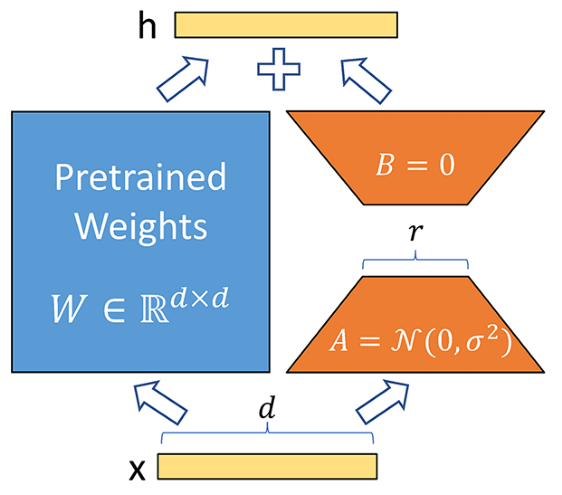

In [4]:
display_img('LoRA.png', 7, 7)

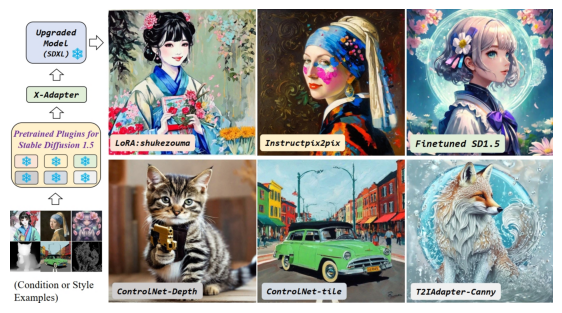

In [5]:
display_img('LoRA_2.png', 7, 7)

In [6]:
start = time.time()

# Finetunning

We are going to do a Finetunning using a CNN model to classify images. This technique can be also used for NLP.

### a. Setting the environment

In [7]:
!pip install -q datasets

In [8]:
!pip install -q loralib

### b. Import Libraries

In [9]:
import loralib as lora

from datasets import load_dataset

import os
import torch
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
from torchvision import models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms

### c. Import Dataset

In [10]:
dataset = load_dataset("food101")

In [11]:
num_labels = len(dataset['train'].features['label'].names)

In [12]:
print(f'Number of labels in the dataset: {num_labels}')

Number of labels in the dataset: 101


In [13]:
def show_limited_images_per_label(dataset, limit = 20):

    plt.figure(figsize=(25, 5))  # Adjust figure size for 10 images per row
    found_labels = set()
    img_count = 0

    for example in dataset:

        label = example['label']

        if label not in found_labels:

            found_labels.add(label)

            img_count += 1

            print(f"Found label {len(found_labels)} / {limit}: {dataset.features['label'].names[label]}")

            # Calculate position for subplot
            ax = plt.subplot(2, 10, img_count)  # Assuming 2 rows, 10 cols for the first 20 images

            image = example['image']

            ax.imshow(image)  # Display the image

            ax.set_title(f"{dataset.features['label'].names[label]}", fontsize = 13)

            ax.axis('off')

            # Stop if we've reached the limit

            if img_count == limit:

                break

    plt.tight_layout()
    plt.show()

Found label 1 / 20: beignets
Found label 2 / 20: prime_rib
Found label 3 / 20: ramen
Found label 4 / 20: hamburger
Found label 5 / 20: bruschetta
Found label 6 / 20: chicken_wings
Found label 7 / 20: pork_chop
Found label 8 / 20: greek_salad
Found label 9 / 20: sashimi
Found label 10 / 20: risotto
Found label 11 / 20: pizza
Found label 12 / 20: eggs_benedict
Found label 13 / 20: guacamole
Found label 14 / 20: chocolate_cake
Found label 15 / 20: miso_soup
Found label 16 / 20: apple_pie
Found label 17 / 20: fried_calamari
Found label 18 / 20: fried_rice
Found label 19 / 20: panna_cotta
Found label 20 / 20: hummus


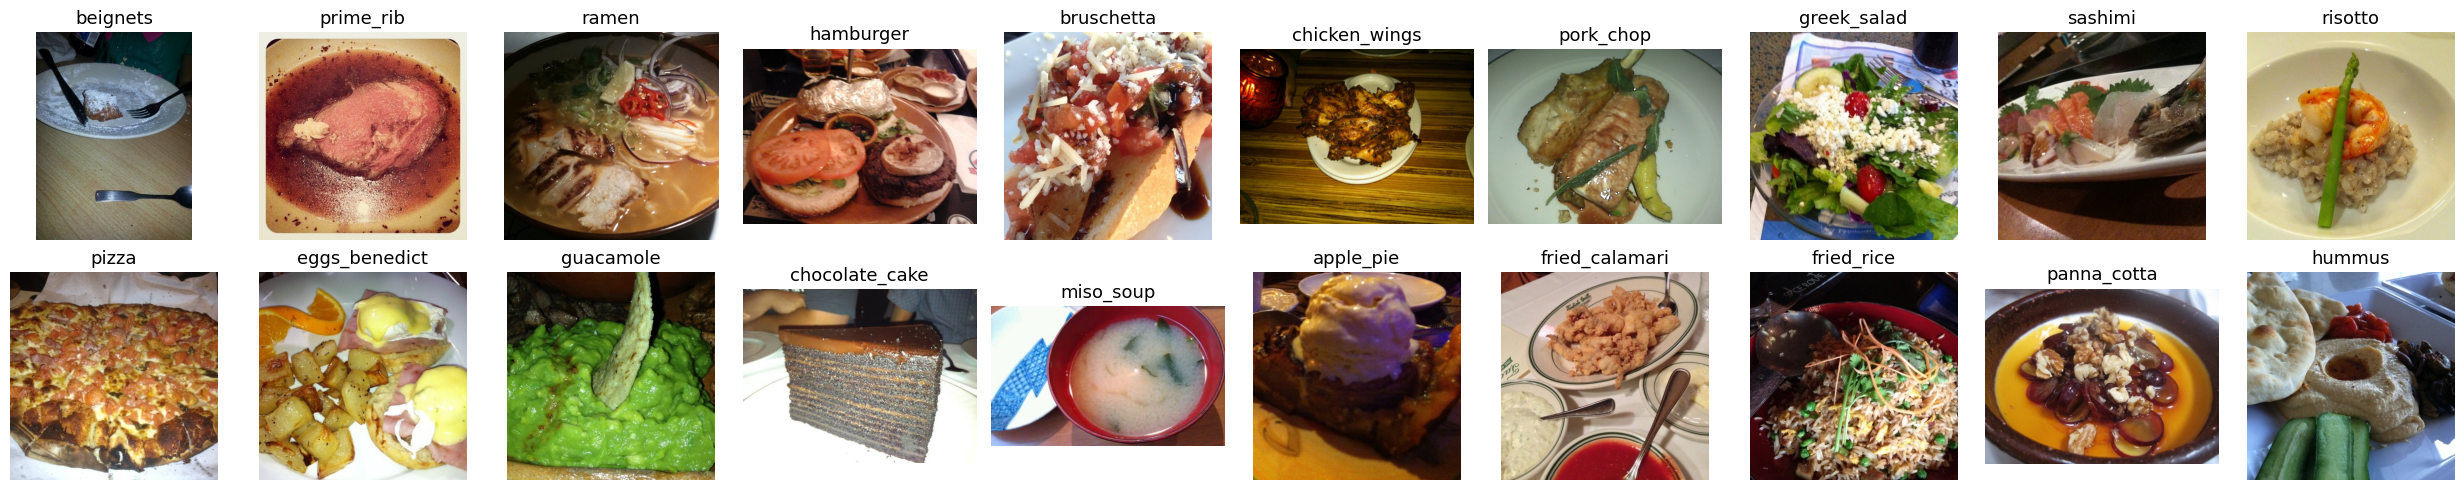

In [14]:
show_limited_images_per_label(dataset['train'], limit = 20)

In [15]:
selected_labels = range(5)

In [16]:
selected_labels

range(0, 5)

In [17]:
filtered_dataset = dataset['train'].filter(lambda example: example['label'] in selected_labels)

In [18]:
shuffled_dataset = filtered_dataset.shuffle(seed = 42)

In [19]:
def partition_dataset(dataset, train_size = 300, val_size = 20, test_size = 50):

    train, val, test = [], [], []

    counts = {label: {'train': 0, 'val': 0, 'test': 0} for label in selected_labels}

    for example in dataset:

        label = example['label']

        if counts[label]['train'] < train_size:

            train.append(example)

            counts[label]['train'] += 1

        elif counts[label]['val'] < val_size:

            val.append(example)

            counts[label]['val'] += 1

        elif counts[label]['test'] < test_size:

            test.append(example)

            counts[label]['test'] += 1

        if all(counts[label][part] >= size for part, size in zip(['train', 'val', 'test'], [train_size, val_size, test_size])):

            continue

    return train, val, test

In [20]:
train, val, test = partition_dataset(shuffled_dataset, train_size = 300, val_size = 50, test_size = 50)

In [21]:
print(f"Total training examples: {len(train)}")
print(f"Total validation examples: {len(val)}")
print(f"Total test examples: {len(test)}")

Total training examples: 1500
Total validation examples: 250
Total test examples: 250


In [22]:
def display_samples(dataset, title):

    plt.figure(figsize=(15, 3))

    plt.suptitle(title)

    for i, label in enumerate(range(5)):

        for example in dataset:

            if example['label'] == label:

                image = example['image']
                plt.subplot(1, 5, i + 1)
                plt.imshow(image)
                plt.title(f"Label {label}")
                plt.axis('off')

                break
    plt.show()

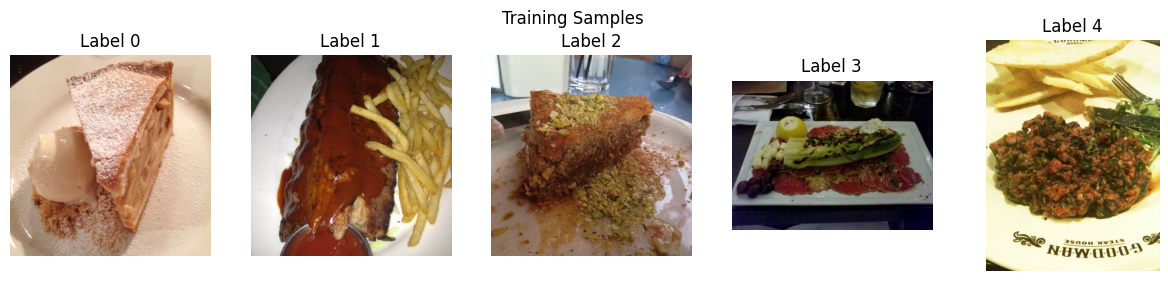

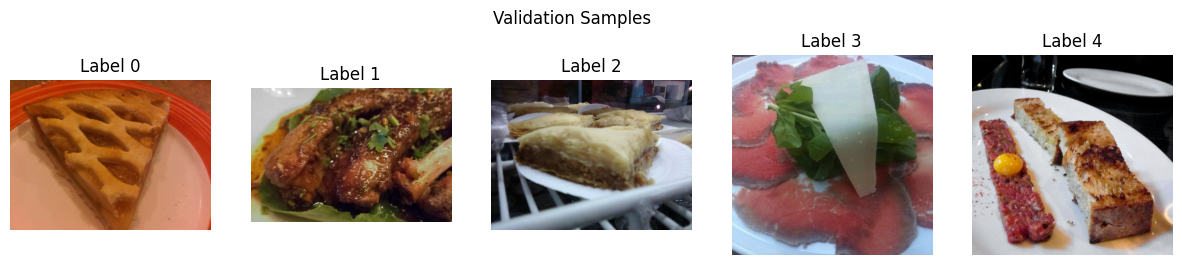

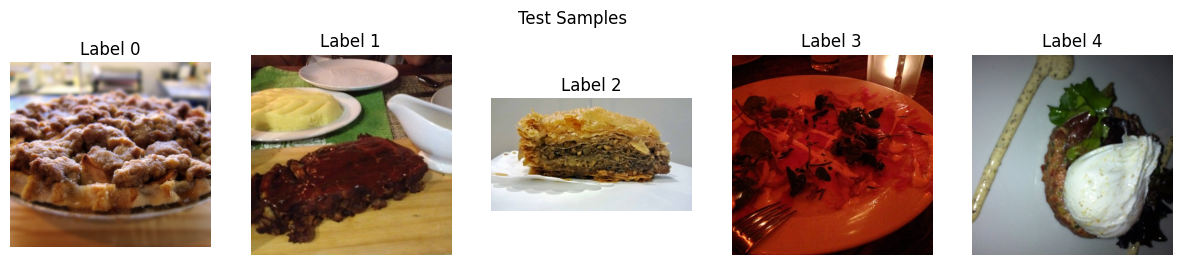

In [23]:
display_samples(train, "Training Samples")
display_samples(val, "Validation Samples")
display_samples(test, "Test Samples")

### c. Load model

In [24]:
model = models.resnet18(pretrained = True)

In [25]:
num_ftrs = model.fc.in_features

In [26]:
print('num_ftrs:', num_ftrs)

num_ftrs: 512


**IMPORTANT**

In [27]:
model.fc = lora.Linear(num_ftrs, 5, r = 32)

Define Transformations

In [28]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

### d. Preparing the Training

In [29]:
class CustomDataset(Dataset):

    def __init__(self, examples):

        self.examples = examples

    def __len__(self):

        return len(self.examples)

    def __getitem__(self, idx):

        example = self.examples[idx]
        image = example['image']
        image = transform(image)
        label = example['label']

        return image, label

In [30]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test)

In [31]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

### e. Training

In [32]:
num_epochs = 20

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
model = model.to(device)

In [35]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [37]:
best_val_accuracy = 0.0
best_model_wts = model.state_dict()

In [38]:
for epoch in range(num_epochs):

    # Train

    model.train()

    running_loss = 0.0

    correct = 0
    total = 0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)

        correct += (predicted == labels).sum().item()

    scheduler.step()

    train_accuracy = 100 * correct / total

    train_losses.append(running_loss / len(train_loader))

    train_accuracies.append(train_accuracy)

    # Validation

    model.eval()

    val_running_loss = 0.0

    correct = 0

    total = 0

    with torch.no_grad():

        for images, labels in val_loader:

            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total

    val_losses.append(val_running_loss / len(val_loader))

    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:

        best_val_accuracy = val_accuracy

        best_model_wts = model.state_dict()

    print(f'Epoch {epoch + 1}, Train Loss: {round(running_loss / len(train_loader), 4)}, Train Accuracy: {round(train_accuracy, 2)}%, Val Loss: {round(val_running_loss / len(val_loader), 2)}, Val Accuracy: {round(val_accuracy, 2)}%')

Epoch 1, Train Loss: 1.0692, Train Accuracy: 60.53%, Val Loss: 1.01, Val Accuracy: 63.6%
Epoch 2, Train Loss: 0.6294, Train Accuracy: 76.87%, Val Loss: 0.6, Val Accuracy: 79.2%
Epoch 3, Train Loss: 0.437, Train Accuracy: 84.47%, Val Loss: 0.86, Val Accuracy: 70.4%
Epoch 4, Train Loss: 0.274, Train Accuracy: 90.27%, Val Loss: 0.72, Val Accuracy: 74.4%
Epoch 5, Train Loss: 0.2229, Train Accuracy: 92.87%, Val Loss: 1.09, Val Accuracy: 69.6%
Epoch 6, Train Loss: 0.256, Train Accuracy: 90.6%, Val Loss: 1.35, Val Accuracy: 71.6%
Epoch 7, Train Loss: 0.1955, Train Accuracy: 93.73%, Val Loss: 1.21, Val Accuracy: 70.0%
Epoch 8, Train Loss: 0.1215, Train Accuracy: 96.0%, Val Loss: 0.56, Val Accuracy: 83.2%
Epoch 9, Train Loss: 0.0423, Train Accuracy: 99.13%, Val Loss: 0.52, Val Accuracy: 83.6%
Epoch 10, Train Loss: 0.0252, Train Accuracy: 99.67%, Val Loss: 0.53, Val Accuracy: 80.8%
Epoch 11, Train Loss: 0.0176, Train Accuracy: 99.73%, Val Loss: 0.51, Val Accuracy: 82.8%
Epoch 12, Train Loss: 0.0

In [39]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [40]:
torch.save(model.state_dict(), 'best_model.pth')

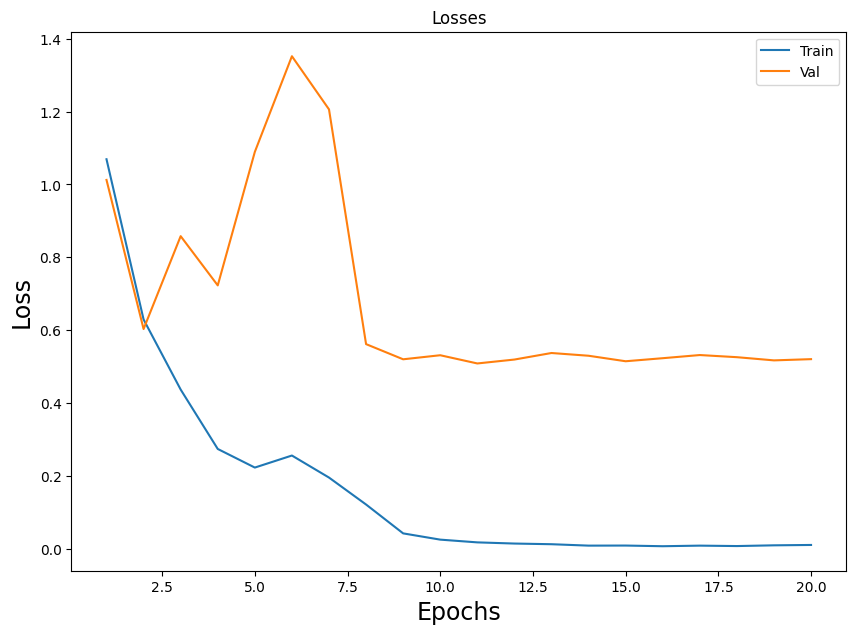

In [41]:
plt.figure(figsize = (10, 7))

plt.plot([i for i in range(1, num_epochs + 1)], train_losses, label = 'Train')
plt.plot([i for i in range(1, num_epochs + 1)], val_losses, label = 'Val')

plt.title('Losses')
plt.legend()

plt.ylabel('Loss', fontsize = 17)
plt.xlabel('Epochs', fontsize = 17)

plt.show()

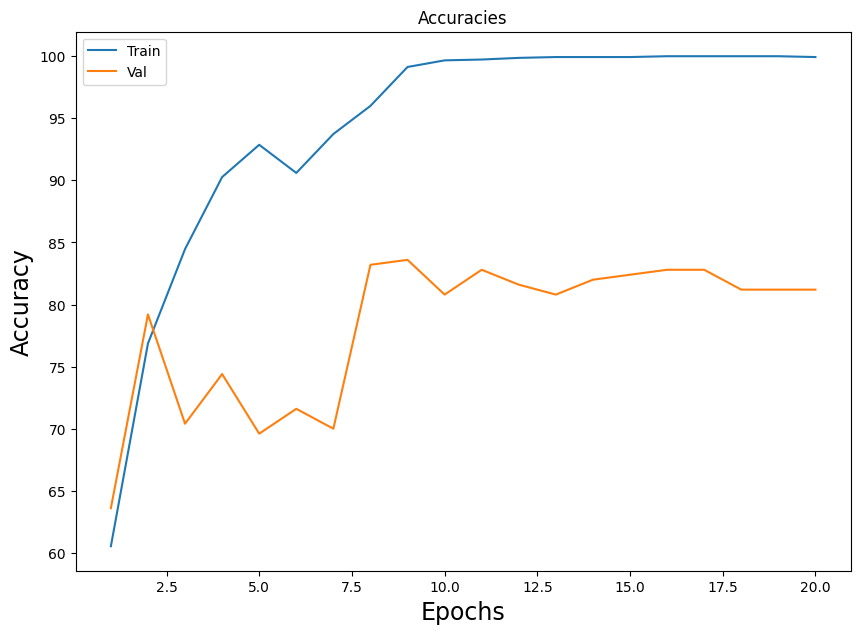

In [42]:
plt.figure(figsize = (10, 7))

plt.plot([i for i in range(1, num_epochs + 1)], train_accuracies, label = 'Train')
plt.plot([i for i in range(1, num_epochs + 1)], val_accuracies, label = 'Val')

plt.title('Accuracies')
plt.legend()

plt.ylabel('Accuracy', fontsize = 17)
plt.xlabel('Epochs', fontsize = 17)

plt.show()

### f. Testing

In [43]:
model.eval()

correct = 0
total = 0

for i, (images, labels) in enumerate(test_loader, start = 1):

  images, labels = images.to(device), labels.to(device)

  outputs = model(images)

  _, predicted = torch.max(outputs, 1)

  total += labels.size(0)
  correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {round(test_accuracy, 2)}%')
plt.show()

Test Accuracy: 85.6%


### Time of execution

In [44]:
end = time.time()

In [45]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 3 minutes and 28 seconds.
